# Santander Customer Transaction Prediction - GBM

In the Kaggle competition, the objective is to identify which customer will make a transaction in the future.

**Link to the competition**: https://www.kaggle.com/c/santander-customer-transaction-prediction/  
**Type of Problem**: Classification  
**Metric for evalution**: AOC (Area Under Curve)

This Python 3 environment comes with many helpful analytics libraries installed
It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv


## Step1: Read Training Data from CSV
Use pandas `read_csv` function to read the data from train.csv into a pandas dataframe.  

Then the dataframe is split into train and test datasets using sklean's `train_test_split` function

In [3]:
input_dir = '/kaggle/input/santander-customer-transaction-prediction/'
df_train = pd.read_csv(input_dir + '/train.csv')
df_train

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


In [4]:
var_columns = [c for c in df_train.columns if c not in ['ID_code','target']]

X = df_train.loc[:,var_columns]
y = df_train.loc[:,'target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((160000, 200), (40000, 200), (160000,), (40000,))

## Step2: Create a simple GBM Model and evaluate performance

Let us look at meaning of some of the parameters which are passed to GradientBoostingClassifier:  
- `n_estimators`: **5000** will be the maximum number of trees in the model
- `learning_rate`: **0.05** will be weights assigned predictions from each tree in the model
- `max_depth`: **3** will be the maximum depth of any one tree in the model
- `subsample`: **50%** of the observations would be used for fitting individual trees
- `validation_fraction`: **10%** of observations would be used for validation
- `n_iter_no_change`: **20** is the stopping criteria for training. If no change is observed in performance for 20 iterations, training stops
- `max_features`: **log2(# features)** will be considered for finding best split

In [5]:
model_gbm = GradientBoostingClassifier(n_estimators=5000,
                                       learning_rate=0.05,
                                       max_depth=3,
                                       subsample=0.5,
                                       validation_fraction=0.1,
                                       n_iter_no_change=20,
                                       max_features='log2',
                                       verbose=1)
model_gbm.fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6520           0.0010           26.23m
         2           0.6481           0.0009           26.36m
         3           0.6453           0.0011           26.27m
         4           0.6484           0.0014           26.27m
         5           0.6409           0.0013           26.06m
         6           0.6425           0.0010           25.99m
         7           0.6382           0.0009           25.86m
         8           0.6422           0.0013           25.84m
         9           0.6392           0.0011           25.88m
        10           0.6455           0.0007           25.89m
        20           0.6266           0.0009           25.70m
        30           0.6193           0.0007           25.48m
        40           0.6116           0.0007           25.41m
        50           0.6023           0.0006           25.33m
        60           0.5939           0.0009           25.30m
       

GradientBoostingClassifier(learning_rate=0.05, max_features='log2',
                           n_estimators=5000, n_iter_no_change=20,
                           subsample=0.5, verbose=1)

Look at how many estimators/trees were finally created during training.

In [6]:
len(model_gbm.estimators_)

1325

In [7]:
y_train_pred = model_gbm.predict_proba(X_train)[:,1]
y_valid_pred = model_gbm.predict_proba(X_valid)[:,1]

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, y_valid_pred)))

AUC Train: 0.9234
AUC Valid: 0.8915


## Step3: Look at performance with respect to number of trees
`staged_predict_proba` function allows us to look at predictions at for different number of trees in the model

In [8]:
y_train_pred_trees = np.stack(list(model_gbm.staged_predict_proba(X_train)))[:,:,1]
y_valid_pred_trees = np.stack(list(model_gbm.staged_predict_proba(X_valid)))[:,:,1]

y_train_pred_trees.shape, y_valid_pred_trees.shape

((1325, 160000), (1325, 40000))

In [9]:
auc_train_trees = [roc_auc_score(y_train, y_pred) for y_pred in y_train_pred_trees]
auc_valid_trees = [roc_auc_score(y_valid, y_pred) for y_pred in y_valid_pred_trees]

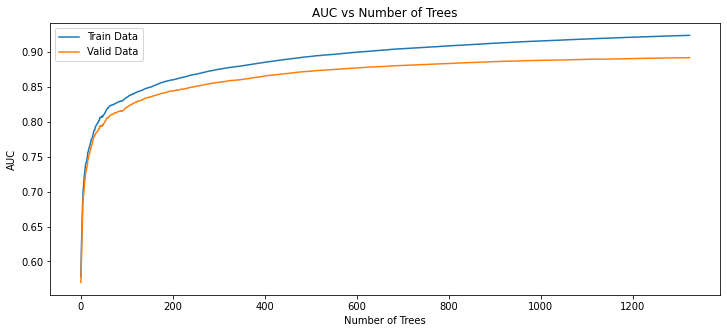

In [10]:
plt.figure(figsize=(12,5))

plt.plot(auc_train_trees, label='Train Data')
plt.plot(auc_valid_trees, label='Valid Data')

plt.title('AUC vs Number of Trees')
plt.ylabel('AUC')
plt.xlabel('Number of Trees')
plt.legend()

plt.show()

## Step4: Feature Importance
Low importance features can be removed from the model for simpler, faster and more stable model

In [11]:
pd.DataFrame({"Variable_Name":var_columns,
              "Importance":model_gbm.feature_importances_}) \
            .sort_values('Importance', ascending=False)

,Variable_Name,Importance
81,var_81,0.029864
139,var_139,0.021895
12,var_12,0.021736
53,var_53,0.018275
22,var_22,0.017721
...,...,...
65,var_65,0.000334
185,var_185,0.000313
14,var_14,0.000222
136,var_136,0.000212


### Step5: Scoring for Test Data
First, read test.csv and sample_submissions.csv

In [12]:
df_test = pd.read_csv(input_dir + 'test.csv')
df_sample_submission = pd.read_csv(input_dir + 'sample_submission.csv')

df_test.shape, df_sample_submission.shape

((200000, 201), (200000, 2))

In [13]:
X_test = df_test.loc[:,var_columns]

df_sample_submission['target'] = model_gbm.predict_proba(X_test)[:,1]
df_sample_submission

,ID_code,target
0,test_0,0.071086
1,test_1,0.226180
2,test_2,0.125941
3,test_3,0.154545
4,test_4,0.056488
...,...,...
199995,test_199995,0.066472
199996,test_199996,0.009356
199997,test_199997,0.006765
199998,test_199998,0.080052


Save the output as a csv

In [14]:
output_dir = '/kaggle/working/'
df_sample_submission.to_csv(output_dir + '/03_gbm_scores.csv', index=False)